In [9]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
# from yellowbrick.classifier import ROCAUC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [10]:
# Load data 
test = pd.read_csv('data/Case2_Test Set Template.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 1 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Month Year;Mapped_GCK;Sales_EUR  140 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


In [11]:
df = pd.read_csv('data/Case2_Sales data.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [ ]:
Macro = pd.read_csv('data/Case2_Market data.csv', delimiter=';')
Macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           221 non-null    object 
 1   China                221 non-null    object 
 2   China.1              221 non-null    object 
 3   France               221 non-null    object 
 4   France.1             221 non-null    object 
 5   Germany              221 non-null    object 
 6   Germany.1            221 non-null    object 
 7   Italy                221 non-null    object 
 8   Italy.1              221 non-null    object 
 9   Japan                221 non-null    object 
 10  Japan.1              221 non-null    object 
 11  Switzerland          220 non-null    object 
 12  Switzerland.1        220 non-null    object 
 13  United Kingdom       221 non-null    object 
 14  United Kingdom.1     203 non-null    object 
 15  United States        221 non-null    obj

In [14]:
df.describe(include='object').T

,count,unique,top,freq
DATE,9802,1216,30.09.2019,14
Mapped_GCK,9802,14,#1,1179
Sales_EUR,9802,2609,0,7134


In [15]:
df.describe().T

,count,unique,top,freq
DATE,9802,1216,30.09.2019,14
Mapped_GCK,9802,14,#1,1179
Sales_EUR,9802,2609,0,7134


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [17]:
df.shape

(9802, 3)

In [22]:
df.head(3)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0


In [ ]:
# Loop through each column in the DataFrame
for column in df.columns:
    
    # Check if the number of unique values in the column is less than 20
    if df[column].nunique() < 20:
        
        print(f"Unique values in '{column}': {df[column].unique()}")
        print(f"Number of unique values: {df[column].nunique()}\n")

Unique values in 'Mapped_GCK': ['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']
Number of unique values: 14



In [31]:
print(df.isnull().sum())

DATE                0
Mapped_GCK          0
Sales_EUR           0
Year                0
Month               0
Quarter             0
Sales_Lag_1         1
Sales_Rolling_3M    2
Sales_Rolling_6M    5
dtype: int64


Non-numeric columns: Index(['DATE', 'Mapped_GCK', 'Sales_Lag_1'], dtype='object')


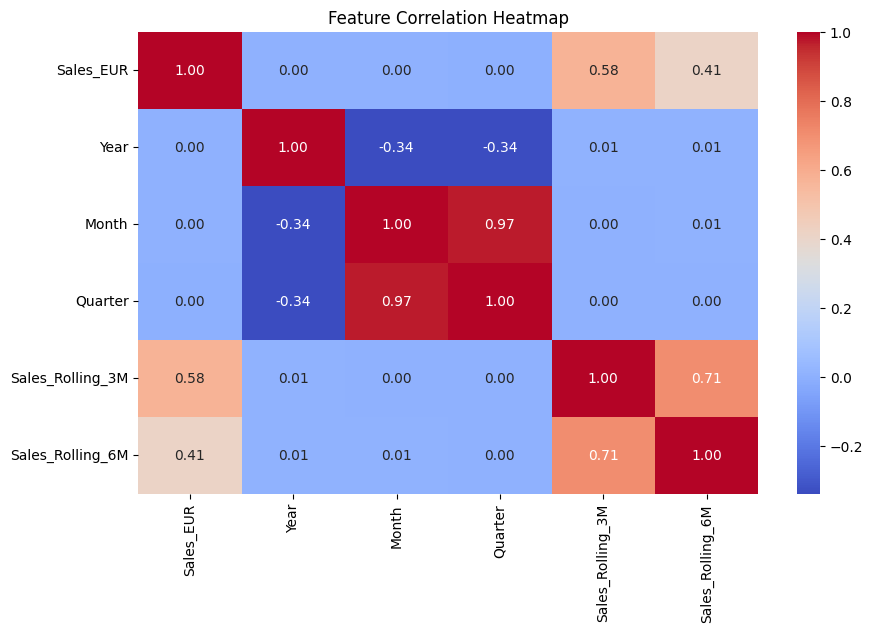

,DATE,Mapped_GCK,Sales_EUR,Year,Month,Quarter,Sales_Lag_1,Sales_Rolling_3M,Sales_Rolling_6M
0,2018-10-01,#1,0.0,2018,10,4,None,NaN,NaN
8398,2018-10-01,#16,0.0,2018,10,4,0,NaN,NaN
410,2018-10-01,#11,0.0,2018,10,4,0,0.0,NaN


In [29]:
# Assuming your Sales_EUR data is in a DataFrame called df
# Ensure DATE column is in DATEtime format
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
df = df.sort_values(by='DATE')

# Feature Engineering: Time-based features
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Quarter'] = df['DATE'].dt.quarter

# Convert sales to numeric if not already
df['Sales_EUR'] = df['Sales_EUR'].astype(str).str.replace(',', '.').astype(float)

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Drop non-numeric columns before correlation
df_numeric = df.drop(columns=non_numeric_cols)

# Plot heatmap with numeric data
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

df.head(3)

array([[<Axes: title={'center': 'Sales_EUR'}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Month'}>],
       [<Axes: title={'center': 'Quarter'}>,
        <Axes: title={'center': 'Sales_Rolling_3M'}>,
        <Axes: title={'center': 'Sales_Rolling_6M'}>],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

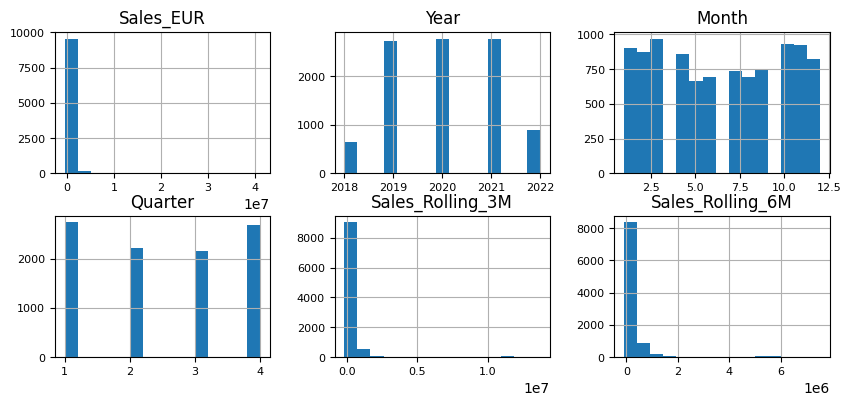

In [32]:
numerical=df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical].hist(bins=15, figsize=(10, 9), layout=(4, 3), xlabelsize=8, ylabelsize=8)

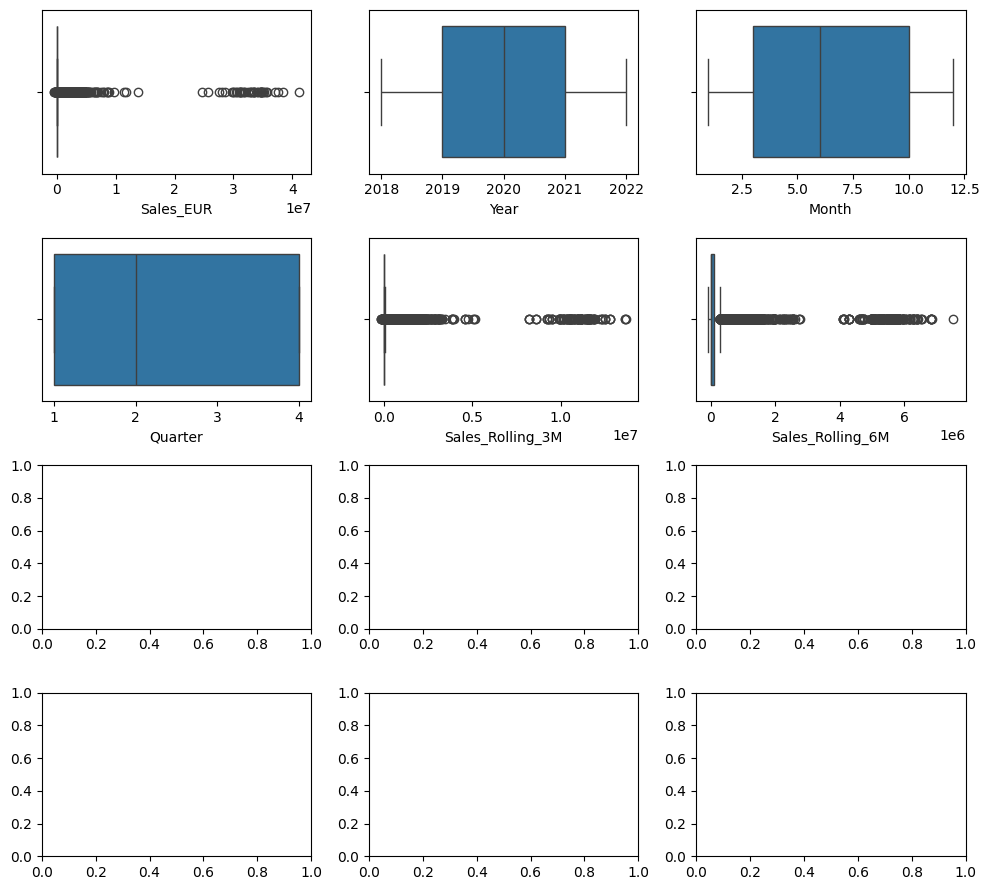

In [34]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(4, 3, figsize=(10, 9))
for var, subplot in zip(df[numerical], ax.flatten()):
    sns.boxplot(x=df[var], ax=subplot)
plt.tight_layout()
plt.show()

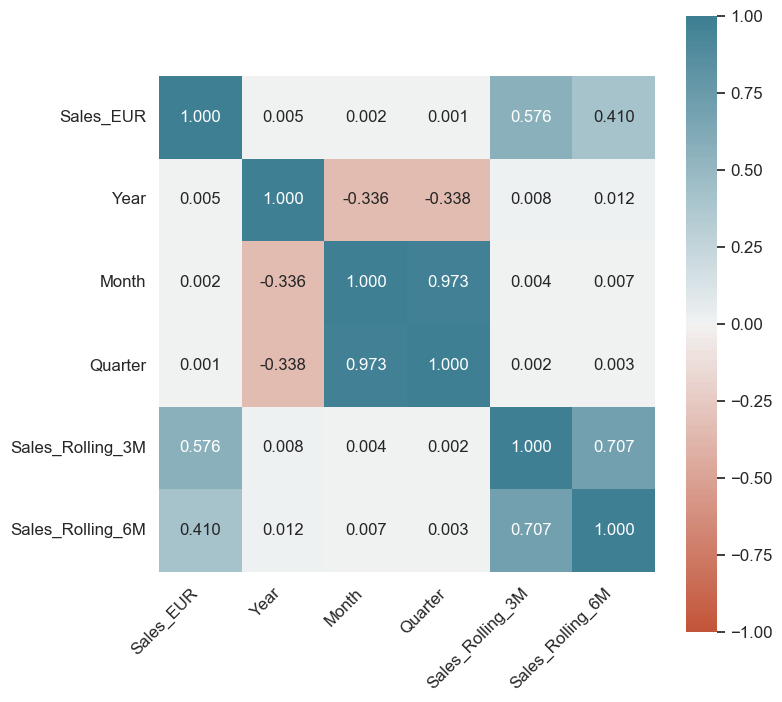

In [35]:
# Plot correlation heatmap of all numeric variables
corr = df[numerical].corr()
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, annot_kws={"size": 12},
    fmt='.3f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);